<a href="https://colab.research.google.com/github/Swelihlelwazi/us-ie-big-data-technologies/blob/master/Postblock%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install apache-beam
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import pandas as pd
import matplotlib.pyplot as plt

# Set up the pipeline options
options = PipelineOptions()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 16.7 MB/s eta 0:00:00
  

In [66]:
#2

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import pandas as pd

# Load the data (assuming you've already uploaded these files to Colab)
users_df = pd.read_csv('users.csv')
orders_df = pd.read_csv('orders.csv', sep=';')

# Convert DataFrames to lists for Beam processing
users_data = users_df.values.tolist()
orders_data = orders_df.values.tolist()

def parse_user(user):
      return {
              'user_id': str(user[0]),
                      'name': user[1],
                              'gender': user[2],
                                      'age': int(user[3]),
                                              'address': user[4],
                                                      'date_joined': user[5]
                                                          }
def parse_order(order):
        return {
                'order_no': order[0],
                        'user_id': str(order[1]),
                                'product_list': order[2],
                                        'date_purchased': order[3]
                                            }

def merge_user_order(element):
      user_id, data = element
      user_info = list(data['users'])[0] if data['users'] else None
      orders = list(data['orders'])

      if user_info:
          return [{
                      'user_id': user_id,
                                  'gender': user_info['gender'],
                                              'age': user_info['age'],
                                                          'order_count': len(orders),
                                                                      'product_list': [order['product_list'] for order in orders]
                                                                              }]
          return []
def count_orders_by_gender(user_order):
      return (user_order['gender'], user_order['order_count'])

def compute_average(orders_per_gender):
    gender, (total_orders, total_customers) = orders_per_gender
    average_orders = total_orders / total_customers
    return f"{gender}: {average_orders:.2f} average orders per customer"

def run_pipeline():
      options = PipelineOptions(['--runner=DirectRunner', '--save_main_session=True'])

      with beam.Pipeline() as p:
# 1. Join the input files as streams using CoGroupByKey
         users = p | 'CreateUsers' >> beam.Create(users_data) | 'ParseUsers' >> beam.Map(parse_user)
         orders = p | 'CreateOrders' >> beam.Create(orders_data) | 'ParseOrders' >> beam.Map(parse_order)

         users_kv = users | 'UserToKV' >> beam.Map(lambda x: (x['user_id'], x))
         orders_kv = orders | 'OrderToKV' >> beam.Map(lambda x: (x['user_id'], x))

         joined = ({'users': users_kv, 'orders': orders_kv} | 'CoGroupByUserId' >> beam.CoGroupByKey())

         merged_result = joined | 'MergeUserOrder' >> beam.FlatMap(merge_user_order)

# 2. Average number of orders for female and male customers
         orders_by_gender = (merged_result
                                | 'CountOrdersByGender' >> beam.Map(count_orders_by_gender)
                                | 'SumOrdersPerGender' >> beam.CombinePerKey(sum))
         customers_by_gender = (merged_result
                                | 'ExtractGenderCustomer' >> beam.Map(lambda x: (x['gender'], x['user_id']))
                                | 'DistinctCustomers' >> beam.Distinct()
                                | 'CountCustomersPerGender' >> beam.combiners.Count.PerKey())
         combined_data = ({'total_orders': orders_by_gender, 'total_customers': customers_by_gender}
                                | 'CoGroupByGender' >> beam.CoGroupByKey())
         average_orders_per_gender = (combined_data
                                | 'ComputeAverage' >> beam.Map(lambda x: (
                                                                               x[0], (sum(x[1]['total_orders']), sum(x[1]['total_customers']))
                                                                                                                    ))
                               | 'CalculateAverageOrders' >> beam.Map(compute_average))

         average_orders_per_gender | 'PrintAverageOrders' >> beam.Map(print)

           # ... (rest of the pipeline remains the same)

           # Run the pipeline
if __name__ == '__main__':
 print("Average number of orders for female and male customers:")
 run_pipeline()






































Average number of orders for female and male customers:
female: 678.52 average orders per customer
male: 678.22 average orders per customer


In [71]:

print("Users DataFrame columns:")
print(users_df.columns)

print("\nOrders DataFrame columns:")
print(orders_df.columns)

print("\nFirst few rows of Users DataFrame:")
print(users_df.head())

print("\nFirst few rows of Orders DataFrame:")
print(orders_df.head())

Users DataFrame columns:
Index(['user_id', 'name', 'gender', 'age', 'address', 'date_joined'], dtype='object')

Orders DataFrame columns:
Index(['order_no', 'user_id', 'product_list', 'date_purchased'], dtype='object')

First few rows of Users DataFrame:
   user_id             name  gender  age                     address  \
0        1     Anthony Wolf    male   73    New Rachelburgh-VA-49583   
1        2  James Armstrong    male   56  North Jillianfort-UT-86454   
2        3        Cody Shaw    male   75         North Anne-SC-53799   
3        4  Sierra Hamilton  female   76     New Angelafurt-ME-46190   
4        5      Chase Davis    male   31    South Bethmouth-WI-18562   

  date_joined  
0  2019/03/13  
1  2020/11/06  
2  2004/05/29  
3  2005/08/26  
4  2018/04/30  

First few rows of Orders DataFrame:
   order_no  user_id             product_list date_purchased
0      1000     1887                  Cassava     2000-01-01
1      1001      838  Calabash, Water Spinach     2000-01

In [73]:
#3
import pandas as pd

# Assuming users_df and orders_df are already loaded

# Merge users and orders dataframes
merged_df = pd.merge(users_df, orders_df, on='user_id')

# Group by user_id and gender, then count orders
user_order_counts = merged_df.groupby(['user_id', 'gender'])['order_no'].count().reset_index(name='order_count')

# Calculate average orders per customer for each gender
gender_averages = user_order_counts.groupby('gender')['order_count'].mean()

# Print results
print("Average number of orders for female and male customers:")
print(f"female: {gender_averages['female']:.2f} average orders per customer")
print(f"male: {gender_averages['male']:.2f} average orders per customer")

# Optional: Display full statistics
print("\nFull statistics:")
print(user_order_counts.groupby('gender')['order_count'].describe())

Average number of orders for female and male customers:
female: 678.52 average orders per customer
male: 678.22 average orders per customer

Full statistics:
         count        mean        std    min    25%    50%    75%    max
gender                                                                  
female  1150.0  678.517391  25.415351  605.0  661.0  678.0  696.0  771.0
male    1207.0  678.222038  26.301078  593.0  661.0  679.0  697.0  767.0


In [78]:
# 4
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import pandas as pd

# Load the data (assuming you've already uploaded these files to Colab)
users_df = pd.read_csv('users.csv')
orders_df = pd.read_csv('orders.csv', sep=';')

# Convert DataFrames to lists for Beam processing
users_data = users_df.values.tolist()
orders_data = orders_df.values.tolist()

def parse_user(user):
      user_id, name, gender, age, address, date_joined = user
      return (user_id, gender)

def parse_order(order):
      order_no, user_id, product_list, date_purchased = order
      return (user_id, 1)

def compute_average(gender_orders):
      gender, orders = gender_orders
      total_orders = sum(orders)
      num_customers = len(orders)
      average_orders = total_orders / num_customers
      return f"{gender}: {average_orders:.2f} average orders per customer"

def run_pipeline():
      options = PipelineOptions()


with beam.Pipeline() as p:
          users = p | 'CreateUsers' >> beam.Create(users_data) | 'ParseUsers' >> beam.Map(parse_user)
          orders = p | 'CreateOrders' >> beam.Create(orders_data) | 'ParseOrders' >> beam.Map(parse_order)
# Calculate total number of orders
          total_orders = (orders | 'CountTotalOrders' >> beam.combiners.Count.Globally()
                                       | 'FormatTotalOrders' >> beam.Map(lambda count: f"Total number of orders processed: {count}"))

# Calculate average orders per gender
          average_orders_per_gender = (
                    {'users': users, 'orders': orders}
                                | 'GroupUserOrders' >> beam.CoGroupByKey()
                                            | 'CountOrdersPerUser' >> beam.Map(lambda kv: (kv[1]['users'][0], len(kv[1]['orders'])))
                                                        | 'GroupByGender' >> beam.GroupByKey()
                                                                    | 'CalculateAverageOrders' >> beam.Map(compute_average)
                                                                            )


# Output results
          average_orders_per_gender | 'PrintAverageOrders' >> beam.Map(print)
          total_orders | 'PrintTotalOrders' >> beam.Map(print)


if __name__ == '__main__':
     print("Average number of orders for female and male customers:")
     run_pipeline()

Total number of orders processed: 1598909
male: 678.22 average orders per customer
female: 678.52 average orders per customer
Average number of orders for female and male customers:


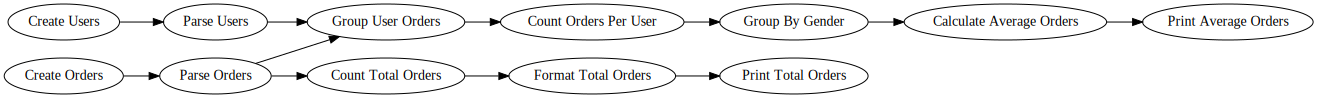

The pipeline graph has been generated and displayed.


In [90]:
#5
import apache_beam as beam
import pandas as pd
from graphviz import Digraph

# Load the data (assuming you've already uploaded these files to Colab)
users_df = pd.read_csv('users.csv')
orders_df = pd.read_csv('orders.csv', sep=';')

# Convert DataFrames to lists for Beam processing
users_data = users_df.values.tolist()
orders_data = orders_df.values.tolist()

def parse_user(user):
      user_id, name, gender, age, address, date_joined = user
      return (user_id, gender)

def parse_order(order):
      order_no, user_id, product_list, date_purchased = order
      return (user_id, 1)

def compute_average(gender_orders):
      gender, orders = gender_orders
      total_orders = sum(orders)
      num_customers = len(orders)
      average_orders = total_orders / num_customers
      return f"{gender}: {average_orders:.2f} average orders per customer"

def generate_pipeline_graph():
                                          dot = Digraph(comment='Apache Beam Pipeline')
                                          dot.attr(rankdir='LR')  # Left to Right layout

                                                  # Create nodes
                                          dot.node('CreateUsers', 'Create Users')
                                          dot.node('ParseUsers', 'Parse Users')
                                          dot.node('CreateOrders', 'Create Orders')
                                          dot.node('ParseOrders', 'Parse Orders')
                                          dot.node('CountTotalOrders', 'Count Total Orders')
                                          dot.node('FormatTotalOrders', 'Format Total Orders')
                                          dot.node('GroupUserOrders', 'Group User Orders')
                                          dot.node('CountOrdersPerUser', 'Count Orders Per User')
                                          dot.node('GroupByGender', 'Group By Gender')
                                          dot.node('CalculateAverageOrders', 'Calculate Average Orders')
                                          dot.node('PrintAverageOrders', 'Print Average Orders')
                                          dot.node('PrintTotalOrders', 'Print Total Orders')

                                                                                                      # Create edges
                                          dot.edge('CreateUsers', 'ParseUsers')
                                          dot.edge('CreateOrders', 'ParseOrders')
                                          dot.edge('ParseOrders', 'CountTotalOrders')
                                          dot.edge('CountTotalOrders', 'FormatTotalOrders')
                                          dot.edge('FormatTotalOrders', 'PrintTotalOrders')
                                          dot.edge('ParseUsers', 'GroupUserOrders')
                                          dot.edge('ParseOrders', 'GroupUserOrders')
                                          dot.edge('GroupUserOrders', 'CountOrdersPerUser')
                                          dot.edge('CountOrdersPerUser', 'GroupByGender')
                                          dot.edge('GroupByGender', 'CalculateAverageOrders')
                                          dot.edge('CalculateAverageOrders', 'PrintAverageOrders')

                                          return dot

                                                                                                                                                      # Generate and display the graph
graph = generate_pipeline_graph()
display(graph)

print("The pipeline graph has been generated and displayed.")


In [92]:
#6

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import pandas as pd

# Load the data (assuming you've already uploaded these files to Colab)
users_df = pd.read_csv('users.csv')
orders_df = pd.read_csv('orders.csv', sep=';')

# Convert DataFrames to lists for Beam processing
users_data = users_df.values.tolist()
orders_data = orders_df.values.tolist()

def parse_user(user):
    user_id, name, gender, age, address, date_joined = user
    age_group = get_age_group(int(age))
    return (user_id, (gender, age_group))

def parse_order(order):
                order_no, user_id, product_list, date_purchased = order
                yam_count = product_list.lower().count('yam')
                return (user_id, (1, yam_count))

def get_age_group(age):
                            if 18 <= age < 28:
                                    return '[18-27)'
                            elif 28 <= age < 38:
                                    return '[28-37)'
                            elif 38 <= age < 47:
                                    return '[37-46)'
                            elif 47 <= age < 56:
                                    return '[46-55)'
                            else:
                                    return 'Other'

def combine_user_order(user_info, order_info):
                                                                                        gender, age_group = user_info
                                                                                        order_count, yam_count = order_info
                                                                                        return (gender, age_group, order_count, yam_count)

def format_result(result):
                                                                                        (gender, age_group), (order_count, yam_count) = result
                                                                                        return f"{gender}, {age_group}: Orders={order_count}, Yams={yam_count}"

def sum_orders_and_yams(elements):
                                                                                     order_count = sum(e[2] if len(e) > 2 else 0 for e in elements)
                                                                                     yam_count = sum(e[3] if len(e) > 3 else 0 for e in elements)
                                                                                     return (order_count, yam_count)


def run_pipeline():
                                                                                                            with beam.Pipeline() as p:
                                                                                                                    users = (p | 'CreateUsers' >> beam.Create(users_data)
                                                                                                                                       | 'ParseUsers' >> beam.Map(parse_user))

                                                                                                                    orders = (p | 'CreateOrders' >> beam.Create(orders_data)
                                                                                                                                                                           | 'ParseOrders' >> beam.Map(parse_order))

                                                                                                                    results = ({'users': users, 'orders': orders}
                                                                                                                                                                                                       | 'GroupUserOrders' >> beam.CoGroupByKey()
                                                                                                                                                                                                                   | 'CombineUserOrder' >> beam.FlatMap(lambda kv: [combine_user_order(u, o) for u in kv[1]['users'] for o in kv[1]['orders']])
                                                                                                                                                                                                                               | 'GroupByGenderAge' >> beam.GroupBy(lambda x: (x[0], x[1]))
                                                                                                                                                                                                                                           | 'SumOrders' >> beam.CombineValues(lambda x: (sum(i[2] for i in x), sum(i[3] for i in x)))
                                                                                                                                                                                                                                                       | 'FormatResult' >> beam.Map(format_result)
                                                                                                                                                                                                                                                               )

                                                                                                                    results | 'PrintResults' >> beam.Map(print)

                                                                                                                                                                                                                                                                                       # Calculate total yams for [18-27) and [28-37) age groups
                                                                                                                    yam_results = (results
                                                                                                                                                                                                                                                                                                           | 'FilterYoungGroups' >> beam.Filter(lambda x: '[18-27)' in x or '[28-37)' in x)
                                                                                                                                                                                                                                                                                                                       | 'ExtractYamCount' >> beam.Map(lambda x: int(x.split('Yams=')[1]))
                                                                                                                                                                                                                                                                                                                                   | 'SumYams' >> beam.CombineGlobally(sum)
                                                                                                                                                                                                                                                                                                                                               | 'FormatYamResult' >> beam.Map(lambda x: f"Total yams purchased by [18-27) and [28-37) age groups: {x}")
                                                                                                                                                                                                                                                                                                                                                           | 'PrintYamResult' >> beam.Map(print)
                                                                                                                                                                                                                                                                                                                                                                   )

if __name__ == '__main__':
                                                                                                                                                                                                                                                                                                                                                                       run_pipeline()

ERROR:apache_beam.runners.common:tuple index out of range [while running 'SumOrders/ParDo(CombineValuesDoFn)']
Traceback (most recent call last):
  File "apache_beam/runners/common.py", line 1495, in apache_beam.runners.common.DoFnRunner.process
  File "apache_beam/runners/common.py", line 688, in apache_beam.runners.common.SimpleInvoker.invoke_process
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/transforms/core.py", line 3069, in process
    accumulator = self.combinefn.merge_accumulators(
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/transforms/core.py", line 1394, in merge_accumulators
    return [self._fn(_ReiterableChain(accumulators))]
  File "<ipython-input-92-d938b020d1b3>", line 64, in <lambda>
    | 'SumOrders' >> beam.CombineValues(lambda x: (sum(i[2] for i in x), sum(i[3] for i in x)))
  File "<ipython-input-92-d938b020d1b3>", line 64, in <genexpr>
    | 'SumOrders' >> beam.CombineValues(lambda x: (sum(i[2] for i in x), sum(i[3] for i in x)))
In

IndexError: tuple index out of range [while running 'SumOrders/ParDo(CombineValuesDoFn)']